In [1]:
!pip install awswrangler

In [1]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from sqlalchemy import create_engine
import os
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt

In [3]:
staging_path = 's3://will-prod-ml-platform-sagemaker-studio/staging/flavia-costa/'
boto3_session = boto3.Session(region_name='sa-east-1')

#### Retirando BU Cobrança

In [13]:
query = """

select 
date_trunc('month', ult_disparo_email) as mes_envio_email --ultimo mes
, date_trunc('month',  ult_disparo_push) as mes_envio_push
, date_trunc('month',  ult_disparo_sms) as mes_envio_sms
, count(distinct cpf) as clientes
from martech_curated_zone.historico_acionamento_pmm_cliente
where lower(bu) <> 'cobranca'
and lower(bu) <> 'cobrança'
and date_trunc('month', ult_disparo_email) <= to_date('2023-09-01', 'yyyy-mm-dd')
and date_trunc('month', ult_disparo_push) <= to_date('2023-09-01', 'yyyy-mm-dd')
and date_trunc('month', ult_disparo_sms) <= to_date('2023-09-01', 'yyyy-mm-dd')
group by 1,2,3


"""

In [4]:
import acessos as ac

In [14]:
df = ac.df_athena_q('flavia-costa', query)

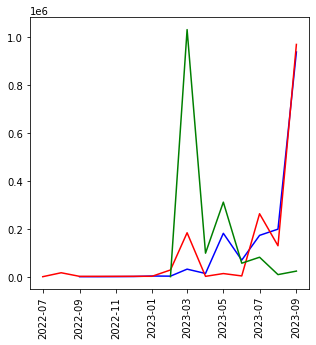

In [15]:
plt.figure(figsize = (5,5))
plt.plot(df.groupby('mes_envio_email').agg({'clientes':['sum']}), color = 'blue')
plt.plot(df.groupby('mes_envio_push').agg({'clientes':['sum']}), color = 'red')
plt.plot(df.groupby('mes_envio_sms').agg({'clientes':['sum']}), color = 'green')
plt.xticks(rotation=90)
plt.show()

## Analisando no nível cliente

In [16]:
query = """

select 
c.cpf
, max(p.ds_cluster_sociodemographic) as persona
, max(case when interacao_email <> 'nunca' then 1 else 0 end) as flag_email
, max(case when interacao_push <> 'nunca' then 1 else 0 end) as flag_push
from martech_curated_zone.historico_acionamento_pmm_cliente c
left join customer_curated_zone.ca_book_cliente cli on (cli.cpf = c.cpf)
left join customer_curated_zone.ca_book_cliente_cluster p on (p.id_customer = cli.id_customer) 
where (ult_disparo_email is not null or ult_disparo_push is not null)
and (interacao_email <> 'nunca' or interacao_push <> 'nunca')
group by 1
order by rand()
limit 500000


"""

# wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# # Run query
# print('Started query')

# df3 = wr.athena.read_sql_query(
#     sql=query,
#     database=None,
#     unload_approach=True,
#     ctas_approach=False,
#     boto3_session=boto3_session,
#     s3_output=staging_path 
# )
# wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

from acessos import df_athena_q

df3 = df_athena_q('flavia-costa', query)


In [17]:
len(df3)

500000

In [6]:
df3

,cpf,persona,flag_email,flag_push,segmento
0,16339164803,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",1,0,2 - Apenas Email
1,07852488382,"22 - Mulher, Até 24 anos, Nordeste",1,0,2 - Apenas Email
2,84180439115,"32 - Homem, 41 anos ou mais, Centro-Oeste e Norte",1,0,2 - Apenas Email
3,05748628627,"25 - Homem, 41 anos ou mais, Sudeste e Sul",1,0,2 - Apenas Email
4,03056209242,"27 - Homem, 25 a 40 anos, Centro-Oeste e Norte",1,0,2 - Apenas Email
...,...,...,...,...,...
499995,84371854915,"21 - Mulher, 41 anos ou mais, Sudeste e Sul",1,0,2 - Apenas Email
499996,17482324607,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",1,1,1 - Engajado em dois canais
499997,08068582576,"22 - Mulher, Até 24 anos, Nordeste",1,1,1 - Engajado em dois canais
499998,00751917508,"19 - Mulher, 41 anos ou mais, Nordeste",0,1,3 - Apenas Push


In [18]:
df3['segmento'] = np.where((df3['flag_email'] == 1) & (df3['flag_push'] == 1), "1 - Engajado em dois canais", 
                    np.where((df3['flag_email'] == 1) & (df3['flag_push'] == 0), "2 - Apenas Email",
                          np.where((df3['flag_email'] == 0) & (df3['flag_push'] == 1), "3 - Apenas Push", "NI")))


df3['segmento'].value_counts()

1 - Engajado em dois canais    437268
3 - Apenas Push                 56718
2 - Apenas Email                 6014
Name: segmento, dtype: int64

In [19]:
df3['segmento'].value_counts(normalize = True)

1 - Engajado em dois canais    0.874536
3 - Apenas Push                0.113436
2 - Apenas Email               0.012028
Name: segmento, dtype: float64

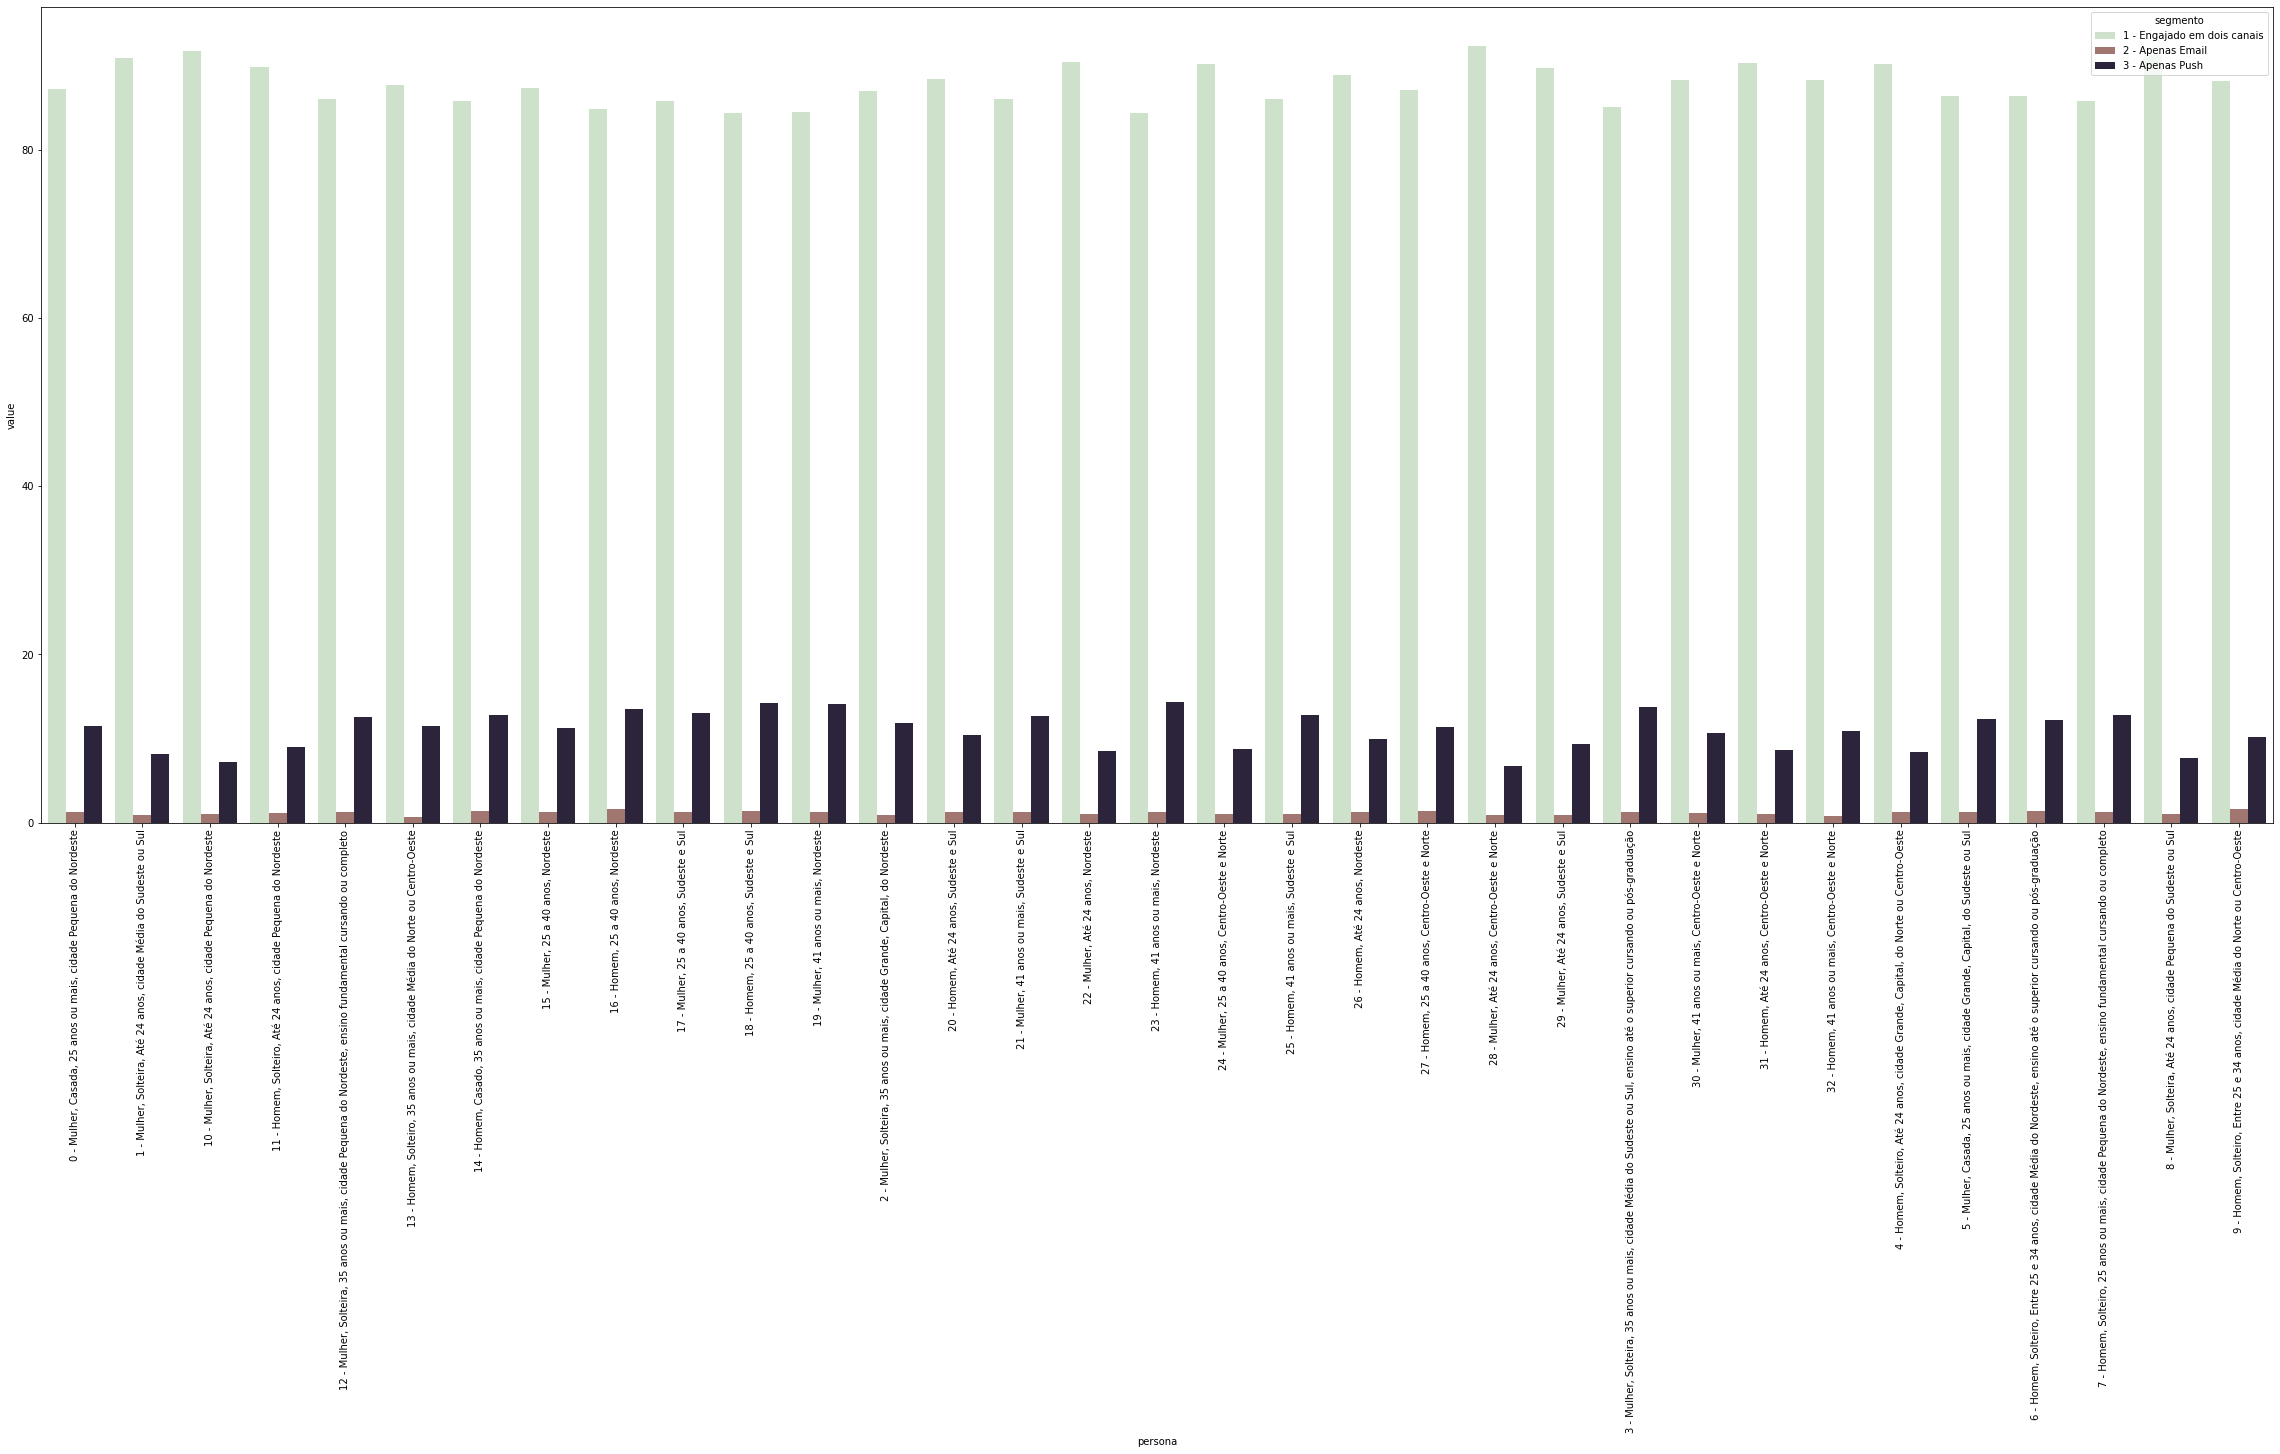

In [20]:
vars_agregacao = ['persona'] #vão estar no x. Precisam ser categóricas

for i in vars_agregacao:
    group_var = 'segmento' #vai estar na legenda
    x_var = i
    campo_contagem = 'count'
    agg = df3.groupby([i, group_var]).agg({'cpf':['count']}) #alterar nome do dataframe e variavel de contagem
    agg.columns = agg.columns.droplevel(0)
    agg = agg.reset_index()
    df_viz = agg.pivot_table(columns=x_var,index = group_var, values=campo_contagem, aggfunc=np.sum)

    for i in df_viz.columns:
        df_viz[i] = df_viz[i] / df_viz[i].sum()

    df_viz = df_viz.reset_index()
    df_viz = pd.melt(df_viz, id_vars=[group_var])
    df_viz['value'] = df_viz['value'] * 100
    x = df_viz[x_var].astype('str')
    y = df_viz[group_var].astype('str')
    z = df_viz.value.round(1)
    plt.figure(figsize = (40,15))
    sns.barplot(data = df_viz, x = x, y = z, hue = y, palette="ch:s=1,rot=-2")
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
df_viz.query('segmento == "2 - Apenas Email"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
97,2 - Apenas Email,"9 - Homem, Solteiro, Entre 25 e 34 anos, cidad...",1.606426
25,2 - Apenas Email,"16 - Homem, 25 a 40 anos, Nordeste",1.550183
31,2 - Apenas Email,"18 - Homem, 25 a 40 anos, Sudeste e Sul",1.419157
61,2 - Apenas Email,"27 - Homem, 25 a 40 anos, Centro-Oeste e Norte",1.416455
19,2 - Apenas Email,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",1.406470
88,2 - Apenas Email,"6 - Homem, Solteiro, Entre 25 e 34 anos, cidad...",1.368078
13,2 - Apenas Email,"12 - Mulher, Solteira, 35 anos ou mais, cidade...",1.331924
22,2 - Apenas Email,"15 - Mulher, 25 a 40 anos, Nordeste",1.327895
34,2 - Apenas Email,"19 - Mulher, 41 anos ou mais, Nordeste",1.280374
82,2 - Apenas Email,"4 - Homem, Solteiro, Até 24 anos, cidade Grand...",1.278898


In [ ]:
df_viz.query('segmento == "2 - Apenas Email"').sort_values(by = 'value', ascending=True).head(10)

,segmento,persona,value
16,2 - Apenas Email,"13 - Homem, Solteiro, 35 anos ou mais, cidade ...",0.671704
79,2 - Apenas Email,"32 - Homem, 41 anos ou mais, Centro-Oeste e Norte",0.808444
64,2 - Apenas Email,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",0.855661
67,2 - Apenas Email,"29 - Mulher, Até 24 anos, Sudeste e Sul",0.935782
37,2 - Apenas Email,"2 - Mulher, Solteira, 35 anos ou mais, cidade ...",0.942532
4,2 - Apenas Email,"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",0.948944
46,2 - Apenas Email,"22 - Mulher, Até 24 anos, Nordeste",0.961153
94,2 - Apenas Email,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",0.984529
7,2 - Apenas Email,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",0.992776
52,2 - Apenas Email,"24 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",0.996476


In [ ]:
df_viz.query('segmento == "3 - Apenas Push"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
50,3 - Apenas Push,"23 - Homem, 41 anos ou mais, Nordeste",14.416776
32,3 - Apenas Push,"18 - Homem, 25 a 40 anos, Sudeste e Sul",14.174230
35,3 - Apenas Push,"19 - Mulher, 41 anos ou mais, Nordeste",14.093458
71,3 - Apenas Push,"3 - Mulher, Solteira, 35 anos ou mais, cidade ...",13.665032
26,3 - Apenas Push,"16 - Homem, 25 a 40 anos, Nordeste",13.504673
29,3 - Apenas Push,"17 - Mulher, 25 a 40 anos, Sudeste e Sul",12.994959
56,3 - Apenas Push,"25 - Homem, 41 anos ou mais, Sudeste e Sul",12.839838
92,3 - Apenas Push,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",12.816408
20,3 - Apenas Push,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",12.798875
44,3 - Apenas Push,"21 - Mulher, 41 anos ou mais, Sudeste e Sul",12.693292


In [ ]:
df_viz.query('segmento == "3 - Apenas Push"').sort_values(by = 'value', ascending=True).head(10)

,segmento,persona,value
65,3 - Apenas Push,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",6.724287
8,3 - Apenas Push,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",7.219805
95,3 - Apenas Push,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",7.716831
5,3 - Apenas Push,"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",8.086073
83,3 - Apenas Push,"4 - Homem, Solteiro, Até 24 anos, cidade Grand...",8.411215
47,3 - Apenas Push,"22 - Mulher, Até 24 anos, Nordeste",8.513073
77,3 - Apenas Push,"31 - Homem, Até 24 anos, Centro-Oeste e Norte",8.567846
53,3 - Apenas Push,"24 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",8.810305
11,3 - Apenas Push,"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...",8.991557
68,3 - Apenas Push,"29 - Mulher, Até 24 anos, Sudeste e Sul",9.264241


In [ ]:
df_viz.query('segmento == "1 - Engajado em dois canais"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
63,1 - Engajado em dois canais,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",92.420052
6,1 - Engajado em dois canais,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",91.787419
93,1 - Engajado em dois canais,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",91.298640
3,1 - Engajado em dois canais,"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",90.964983
45,1 - Engajado em dois canais,"22 - Mulher, Até 24 anos, Nordeste",90.525774
75,1 - Engajado em dois canais,"31 - Homem, Até 24 anos, Centro-Oeste e Norte",90.415157
81,1 - Engajado em dois canais,"4 - Homem, Solteiro, Até 24 anos, cidade Grand...",90.309887
51,1 - Engajado em dois canais,"24 - Mulher, 25 a 40 anos, Centro-Oeste e Norte",90.193219
9,1 - Engajado em dois canais,"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...",89.931113
66,1 - Engajado em dois canais,"29 - Mulher, Até 24 anos, Sudeste e Sul",89.799977


In [ ]:
print(df3['persona'].unique())

['16 - Homem, 25 a 40 anos, Nordeste'
 '0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste'
 '14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste'
 '20 - Homem, Até 24 anos, Sudeste e Sul'
 '8 - Mulher, Solteira, Até 24 anos, cidade Pequena do Sudeste ou Sul'
 '21 - Mulher, 41 anos ou mais, Sudeste e Sul'
 '17 - Mulher, 25 a 40 anos, Sudeste e Sul'
 '19 - Mulher, 41 anos ou mais, Nordeste' None
 '27 - Homem, 25 a 40 anos, Centro-Oeste e Norte'
 '25 - Homem, 41 anos ou mais, Sudeste e Sul'
 '26 - Homem, Até 24 anos, Nordeste'
 '10 - Mulher, Solteira, Até 24 anos, cidade Pequena do Nordeste'
 '15 - Mulher, 25 a 40 anos, Nordeste'
 '2 - Mulher, Solteira, 35 anos ou mais, cidade Grande, Capital, do Nordeste'
 '23 - Homem, 41 anos ou mais, Nordeste'
 '30 - Homem, Até 24 anos, Centro-Oeste e Norte'
 '9 - Homem, Solteiro, Entre 25 e 34 anos, cidade Média do Norte ou Centro-Oeste'
 '12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental 

Pontos importantes

- Campanhas muito concentradas em email
- Investigar o pouco engajamento de push
- Muitos clientes com engajamento apenas em email e isso varia de acordo com características do cliente
- Um modelo seria viável no momento apemas para propensão em email mas não performaria bem para push
- Caso o modelo seja multicanal definir se o modelo vai considerar como target o engajamento + conversão após

To do
- ppt rápido + pontos acima
- nova reunião e próximos passos